# Task6

Necessary imports:

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## Calibration


### Speed calibration 

Average calibration speed: 0.0551 m/s


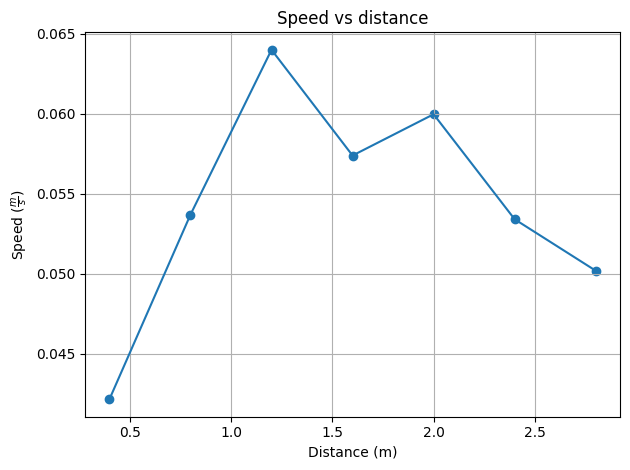

In [49]:


data_speed_calibration = np.loadtxt('../data/task4/robot_speed_task4.csv', delimiter=',', dtype='double')
distance_marks_cm = data_speed_calibration[:,0]/100 # to meters
t_n = data_speed_calibration[:,1]
speeds = np.zeros(len(t_n))

for i,tn in enumerate(t_n):
    if(i==0):
        speeds[i] = distance_marks_cm[i]/tn
    else:
        speeds[i] = (distance_marks_cm[i]-distance_marks_cm[i-1])/tn

plt.figure()
plt.plot( distance_marks_cm,speeds)
plt.scatter(distance_marks_cm,speeds)
plt.title("Speed vs distance")
plt.ylabel("Speed ($\\frac{m}{s})$")
plt.xlabel("Distance (m)")
plt.grid()
plt.tight_layout()

calibration_speed = np.round(np.mean(speeds[0:-1]),4)
speed_100 = calibration_speed*100/30 # linear speed gain (calibration was 30% PWM)
print(f'Average calibration speed: {calibration_speed} m/s')

### Gyroscope calibration

Angular velocity bias: 0.0027
Angular velocity variance: 1e-05


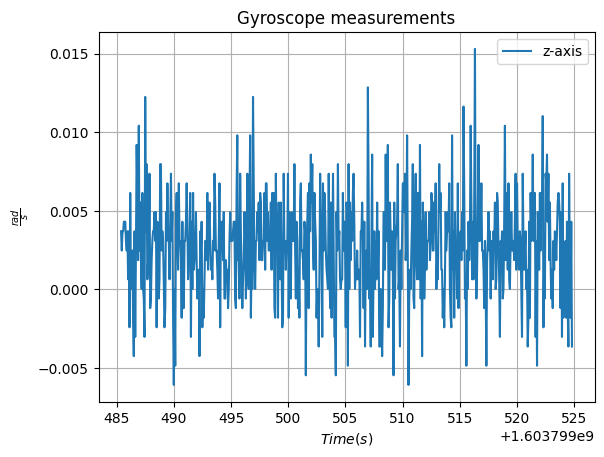

In [50]:

IMU_data_calibration = np.loadtxt('../data/task1/imu_reading_task1.csv',delimiter=',',dtype='double')
gyro_time_calibration = IMU_data_calibration[:,0]
gyro_z_calibration = IMU_data_calibration[:,8]*np.pi/180 # z-axis, to radians/s

gyro_z_bias = np.round(np.mean(gyro_z_calibration),4)
gyro_z_var = np.round(np.var(gyro_z_calibration),6)

plt.figure()
plt.plot(gyro_time_calibration,gyro_z_calibration)
plt.title('Gyroscope measurements')
plt.xlabel('$Time (s)$')
plt.ylabel('$\\frac{rad}{s}$')
plt.legend(['z-axis'])
plt.grid()

print(f'Angular velocity bias: {gyro_z_bias}')
print(f'Angular velocity variance: {gyro_z_var}')

## Dead reckoning

### Loading data

In [51]:
motor_data = np.loadtxt('../data/task6-task7/motor_control_tracking_task6.csv', delimiter=',',dtype='float')
motor_time = motor_data[:,0]
motor_left = motor_data[:,1]
motor_right = motor_data[:,2]

IMU_data = np.loadtxt('../data/task6-task7/imu_tracking_task6.csv',delimiter=',',dtype='float')
gyro_time = IMU_data[:,0]
gyro_z = IMU_data[:,8]*np.pi/180 # to radians
gyro_z = gyro_z-gyro_z_bias # subtracting bias
robot_speed_estimates = (motor_left+motor_right)/2*speed_100 #averaged speed of both sides

### Model and estimation definitions

In [52]:
f_robot = lambda x,u: np.array( [u[0]*np.cos(x[2]), 
                                 u[0]*np.sin(x[2]), 
                                 u[1]] )

def Euler_method(func, u, x0, T):
    x = np.zeros((len(T),3))
    x[0] = x0
    for n in range(1, len(T)):
        dt = T[n] - T[n-1]
        x[n,:] = x[n-1,:] + func(x[n-1,:], u[n-1,:]) * dt
    return x

def dead_reconing_jacobian(x, u):
    jac = np.array([ [0, 0,  -u[0] * np.sin(x[2])], 
                     [0, 0,  u[0] * np.cos(x[2])], 
                     [0, 0,  0] ])
    return jac

def linearization_solution(f, jac, t, x0, u):
    x = np.zeros((t.shape[0],x0.shape[0]))
    I = np.eye(x0.shape[0])
    x[0] = x0
    for i in range(1,t.shape[0]):
        dt = t[i] - t[i-1]
        A = jac(x[i-1],u[i-1])
        F = (I + 0.5*A*dt + A@A*dt*dt/2) * dt  # this is an approximation
        x[i] = x[i-1] + F @ f(x[i-1],u[i-1])
    return x


### Combining speed and gyroscope data

Zero-order hold is used for the speed data since the sampling frequency of gyroscope is much higher. 

To make the data more accurate, an assumption was made that the wheels do not move backwards (confirmed from robot code). Therefore, we know that when both motors have the same input (the speed is the same for both sides), the angular frequency should be 0.

In [53]:
k = 0
u_robot = np.zeros((gyro_z.shape[0],2))
for i, speed in enumerate(robot_speed_estimates):

    motor_timestamp = motor_time[i]
    for j, ang_velocity in enumerate(gyro_z[k:-1]):
        gyro_timestamp = gyro_time[k+j]
        if(gyro_timestamp>motor_timestamp):
            k = k+j
            break

        u_robot[k+j,0] = speed
        u_robot[k+j,1] = 0 if (motor_left[i]== motor_right[i]) else ang_velocity
        # u_robot[k+j,1] = ang_velocity
    if (k >= (len(gyro_z)-1)):
        break

### Dead-reckoning solution

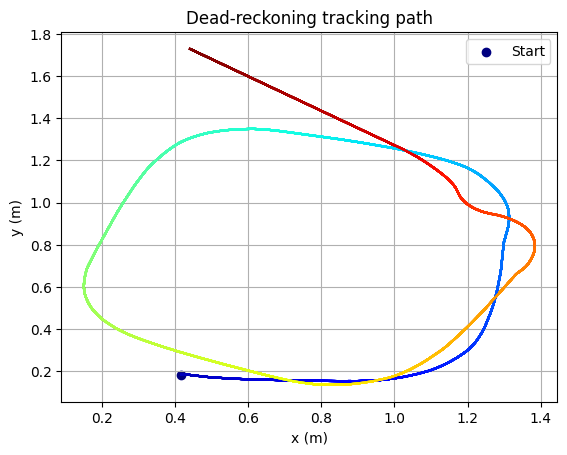

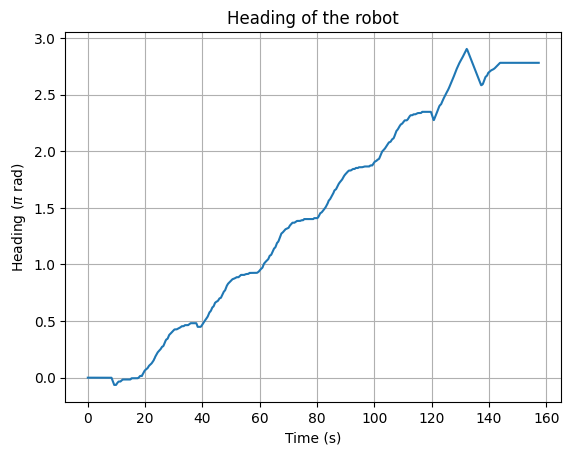

In [54]:

x_robot_0 = np.array([0.417,0.185,0])
# dead_reckoning = Euler_method(f_robot, u_robot, x_robot_0, gyro_time)
dead_reckoning = linearization_solution(f_robot,
                                  dead_reconing_jacobian, 
                                  gyro_time, 
                                  x_robot_0, 
                                  u_robot)


x = dead_reckoning[:,0]
y = dead_reckoning[:,1]

MAP = 'jet'
NPOINTS = len(x)

fig = plt.figure()
ax1 = fig.add_subplot(111) 
cm = plt.get_cmap(MAP)
for i in range(10):
    ax1.set_prop_cycle('color',[cm(1.0*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    for i in range(NPOINTS-1):
        plt.plot(x[i:i+2],y[i:i+2])
plt.title("Dead-reckoning tracking path")
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.scatter(x[0],y[0]).set_label('Start')
plt.legend()
plt.grid()

plt.figure()
plt.plot(gyro_time-gyro_time[0],dead_reckoning[:,2]/np.pi)
plt.title("Heading of the robot")
plt.xlabel("Time (s)")
plt.ylabel("Heading ($\\pi$ rad)")
plt.grid()
